<a href="https://www.kaggle.com/code/tarekyahia/fine-tune-approach?scriptVersionId=160012557" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib .pyplot as plt
import re
import random
import os
from sklearn.model_selection import StratifiedGroupKFold,GroupKFold,KFold
import torch
import torch.nn.functional as F
from torch import nn 
from datasets import Dataset,DatasetDict,Value
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, AdamW
from datasets import DatasetDict
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from transformers import TrainingArguments,Trainer
from transformers import AutoTokenizer, AutoModel, AutoConfig
from copy import deepcopy
from torch.nn.functional import cross_entropy



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# CFG
class CFG:
    n_fold = 5 # use much data in training as possible for the bublic version
    trn_fold = 2
    batch_size = 8
    epochs = 5
    seed = 42
    model_id = "/kaggle/input/debertav3base"
    lr = 8e-5
    weight_decay = 0.01
    num_workers = 4
    gradient_accumulation_steps = 2
    
tokenizer = AutoTokenizer.from_pretrained(CFG.model_id)
CFG.tokenizer = tokenizer

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
# TO SAVE THE MODELS IF NEEDED 
if not os.path.exists('models'):
    os.makedirs('models')
OUTPUT_DIR = '/kaggle/working/models/'

In [4]:
train = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv")
train = train.sample(100).reset_index()
test = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv")
display(train.head())
display(test.head())

,index,id,anchor,target,context,score
0,22477,bd3eabee36e07efa,orthogonal acceleration,time of flight,H05,0.25
1,7801,acb8949df15c6ba8,control in steps,regulating unit,B24,0.25
2,12899,fe6590f23533834d,finger actuator,soldering frame,B23,0.25
3,23951,fe81636f49047899,perfluoroalkyl group,fluorocarbon group,C07,0.50
4,8244,8349b1e15f96e55b,cyclic alcohols,alcoholism,C07,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [5]:
# RELATED DATA
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    '''
    return : Dictionary
    '''
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results

In [6]:
cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)

In [7]:
train.head()

,index,id,anchor,target,context,score,context_text
0,22477,bd3eabee36e07efa,orthogonal acceleration,time of flight,H05,0.25,ELECTRICITY. ELECTRIC TECHNIQUES NOT OTHERWISE...
1,7801,acb8949df15c6ba8,control in steps,regulating unit,B24,0.25,PERFORMING OPERATIONS; TRANSPORTING. GRINDING;...
2,12899,fe6590f23533834d,finger actuator,soldering frame,B23,0.25,PERFORMING OPERATIONS; TRANSPORTING. MACHINE T...
3,23951,fe81636f49047899,perfluoroalkyl group,fluorocarbon group,C07,0.50,HEMISTRY; METALLURGY. ORGANIC CHEMISTRY
4,8244,8349b1e15f96e55b,cyclic alcohols,alcoholism,C07,0.00,HEMISTRY; METALLURGY. ORGANIC CHEMISTRY


In [8]:
# groub by the anchor and context and add them to the inputs

targets = train.groupby(['anchor', 'context'])['target'].apply(list).reset_index(name='targets')
train = pd.merge(train, targets, on=['anchor','context'], how='inner') # join
train['targets_list'] = train.apply(lambda row: [item for item in row['targets'] if item != row['target']], axis=1) # delete 
train['n_targets'] = train.targets.apply(len) # for sorting if needed
train['targets'] = train.targets_list.apply(lambda l: '; '.join(l)) # add ; from list to one row , do it in the Dataset class
# new input for sorting only, i will make this combination again in the Dataset class to apply the shuffle trick
train['inputs'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']  + '[SEP]' + train['targets']
train.head()

,index,id,anchor,target,context,score,context_text,targets,targets_list,n_targets,inputs
0,22477,bd3eabee36e07efa,orthogonal acceleration,time of flight,H05,0.25,ELECTRICITY. ELECTRIC TECHNIQUES NOT OTHERWISE...,,[],1,orthogonal acceleration[SEP]time of flight[SEP...
1,7801,acb8949df15c6ba8,control in steps,regulating unit,B24,0.25,PERFORMING OPERATIONS; TRANSPORTING. GRINDING;...,,[],1,control in steps[SEP]regulating unit[SEP]PERFO...
2,12899,fe6590f23533834d,finger actuator,soldering frame,B23,0.25,PERFORMING OPERATIONS; TRANSPORTING. MACHINE T...,,[],1,finger actuator[SEP]soldering frame[SEP]PERFOR...
3,23951,fe81636f49047899,perfluoroalkyl group,fluorocarbon group,C07,0.50,HEMISTRY; METALLURGY. ORGANIC CHEMISTRY,,[],1,perfluoroalkyl group[SEP]fluorocarbon group[SE...
4,8244,8349b1e15f96e55b,cyclic alcohols,alcoholism,C07,0.00,HEMISTRY; METALLURGY. ORGANIC CHEMISTRY,,[],1,cyclic alcohols[SEP]alcoholism[SEP]HEMISTRY; M...


In [9]:
# do the same to the test data

targets = test.groupby(['anchor', 'context'])['target'].apply(list).reset_index(name='targets')
test = pd.merge(test, targets, on=['anchor','context'], how='inner') # join
test['targets_list'] = test.apply(lambda row: [item for item in row['targets'] if item != row['target']], axis=1) # delete the current target from the list
test['n_targets'] = test.targets.apply(len) # not important
test['targets'] = test.targets_list.apply(lambda l: '; '.join(l)) # add ; from list to one row
# new input
test['inputs'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text'] + '[SEP]' + test['targets'] # prepare for predicting
test.head()

,id,anchor,target,context,context_text,targets,targets_list,n_targets,inputs
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,,[],1,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,,[],1,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,,[],1,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,,[],1,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,,[],1,neural stimulation[SEP]artificial neural netwo...


In [10]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4}) # for the Stratified ( convert to int )
Fold = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'],train['anchor'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


fold
0    19
1    18
2    22
3    21
4    20
dtype: int64

> sort the df then cutting it to batches, for tokenize every batch with the max lens of them, \
> another solution : loop over every batch in the training loop, i think is easier, but i implement this approach and i love to use it^^.

In [11]:
# batch max_len to overcome the GPU limitations problem
def tokenize_text(text):
    '''
    tokenize to sorting purpose
    '''
    inputs = CFG.tokenizer(text,
                           add_special_tokens=True,
                #           max_length=CFG.max_len,
                 #          padding="max_length",
                          # return_token_type_ids = False,
                          # return_attention_mask = False,
                           return_offsets_mapping=False) # pass only text
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs   


def sort_df_batch_lens(df,bs):
    '''
    sort df by the inputs tokenize count then add specific max len for every batch, instead of the max_len for all, this is more and more efficient to the GPU ram 
    '''
    
    dst_df = deepcopy(df)

    # sort by token num
    length = [len(tokenize_text(inputs)['input_ids']) for inputs in dst_df['inputs']]
    
    #   length = len(tokenizer(text, context_text, add_special_tokens=True)['input_ids'])
    #   input_lengths.append(length)   
    dst_df['input_lengths'] = length
    #print(dst_df['input_lengths'])
    length_sorted_idx = np.argsort([-l for l in length])
    
    # sort dataframe
    sort_df = dst_df.iloc[length_sorted_idx].copy()

    # calc max_len per batch
    sorted_input_length = sort_df['input_lengths'].values
    batch_max_length = np.zeros_like(sorted_input_length)
    for i in range((len(sorted_input_length)//bs)+1):
        if len(sorted_input_length[i*bs:(i+1)*bs]) != 0: # solve issue, in some batches the array is empty
            CFG.last_batch_max_len = np.max(sorted_input_length[i*bs:(i+1)*bs])
        batch_max_length[i*bs:(i+1)*bs] = CFG.last_batch_max_len # last batch if the array is empty
    sort_df['batch_max_length'] = batch_max_length
    
    return sort_df

In [12]:
# df -> Dataset
def prepare_text(cfg,text,batch_len):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=batch_len,
                           padding="max_length",
                         #  padding=True, # if i pass batches with map function and be batch = True, but i use Dataset class
                         #  truncation=True,
                           return_offsets_mapping=False) # pass only text
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs   

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, cfg, df):
        # super(TrainDataset, self).__init__(self)
        self.cfg = cfg
        self.batch_max_len = df['batch_max_length'].values
        # self.texts = df['inputs'].values
        self.anchor = df['anchor'].values
        self.targets_list = df['targets_list'].values
        self.context_text = df['context_text'].values
        self.target = df['target'].values
        self.sep = '[SEP]'
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        
        # the targets is shared with very little change for every group, shuffle is a trick 
        # shuffle in-place every call 
        random.shuffle(self.targets_list[item])
        self.targets = '; '.join(self.targets_list[item]) # from list to one long string
        
        self.input = self.anchor[item] + self.sep + self.target[item] + self.sep  + self.context_text[item]  + self.sep + self.targets # the item input

        inputs = prepare_text(self.cfg, self.input,self.batch_max_len[item])
        inputs['label'] = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs

In [13]:
# evaluation metric
def corr(eval_pred): 
    return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [14]:
# reinitializing every new training in the validation folds
def reinitializing_model():
    return AutoModelForSequenceClassification.from_pretrained(CFG.model_id, num_labels=1)

In [15]:
def get_trainer(train_dataset,valid_dataset):
    """
    merge the suitable pre-trained model architecture with some best use hyperparameters with the data 
    """
    
    # reinitializing the instante model to prevent data leakage
    CFG.model = reinitializing_model()
    
    
    model_name = f"{CFG.model_id}-finetuned"
    
    args = TrainingArguments(OUTPUT_DIR+model_name, learning_rate=CFG.lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
          evaluation_strategy='epoch', per_device_train_batch_size=CFG.batch_size, per_device_eval_batch_size=CFG.batch_size*2,
           num_train_epochs=CFG.epochs, weight_decay=CFG.weight_decay, report_to='none',
                             gradient_accumulation_steps = CFG.gradient_accumulation_steps,load_best_model_at_end=True,save_strategy = "epoch") 
    
    
    return Trainer(CFG.model, args, train_dataset=train_dataset,eval_dataset=valid_dataset,
                   tokenizer=CFG.tokenizer, compute_metrics=corr)

In [16]:
def train_loop(folds, fold):
    # ====================================================
    # fine-tune
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    
    # batched and sorted for GPU limitation
    train_folds = sort_df_batch_lens(train_folds,CFG.batch_size)
    valid_folds = sort_df_batch_lens(valid_folds,CFG.batch_size)
    valid_labels = valid_folds['score'].values
    
    
    train_dataset = TrainDataset(CFG,train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    model = get_trainer(train_dataset,valid_dataset)
    model.train()
    
    preds = model.predict(valid_dataset).predictions.astype(float).flatten()
    valid_folds['pred'] = preds

        
    return valid_folds,model

In [17]:
# on the all folds
oof_df = pd.DataFrame()
for fold in range(CFG.trn_fold):
    _oof_df,model = train_loop(train, fold)
    oof_df = pd.concat([oof_df, _oof_df])
oof_df = oof_df.reset_index(drop=True)
print(f"results = {np.corrcoef(oof_df['score'] ,oof_df['pred'] )[0][1]}")
oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Pearson
0,No log,0.075630,0.108571
2,No log,0.080550,0.497916
4,No log,0.075234,0.567058


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Pearson
0,No log,0.087870,-0.413779
2,No log,0.047883,0.422194
4,No log,0.053630,0.464236


Checkpoint destination directory /kaggle/working/models//kaggle/input/debertav3base-finetuned/checkpoint-5 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory /kaggle/working/models//kaggle/input/debertav3base-finetuned/checkpoint-11 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory /kaggle/working/models//kaggle/input/debertav3base-finetuned/checkpoint-16 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory /kaggle/working/models//kaggle/input/debertav3base-finetuned/checkpoint-22 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory /kaggle/working/models//kaggle/input/debertav3base-finetuned/checkpoint-25 already exists and is non-empty.Saving will proceed but saved results may be invalid.


results = 0.4710794416844827


In [18]:
print(f"results = {np.corrcoef(oof_df['score'] ,oof_df['pred'] )[0][1]}")
oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')

results = 0.4710794416844827


### error analysis

In [19]:

oof_df.head()

,index,id,anchor,target,context,score,context_text,targets,targets_list,n_targets,inputs,score_map,fold,input_lengths,batch_max_length,pred
0,23380,b299775908f98700,panel frame,reactor,C25,0.25,HEMISTRY; METALLURGY. ELECTROLYTIC OR ELECTROP...,,[],1,panel frame[SEP]reactor[SEP]HEMISTRY; METALLUR...,1,0,33,33,0.362793
1,14277,6b16961b9c1aa49a,fused layer,processing of layers,B29,0.50,PERFORMING OPERATIONS; TRANSPORTING. WORKING O...,,[],1,fused layer[SEP]processing of layers[SEP]PERFO...,2,0,32,33,0.369141
2,26824,853bc4fbc316d406,radio wave transmission,decorative,B29,0.00,PERFORMING OPERATIONS; TRANSPORTING. WORKING O...,,[],1,radio wave transmission[SEP]decorative[SEP]PER...,0,0,31,33,0.367676
3,3769,b21cb7b72ba1976b,brake arms,brakes arms,B62,1.00,PERFORMING OPERATIONS; TRANSPORTING. LAND VEHI...,,[],1,brake arms[SEP]brakes arms[SEP]PERFORMING OPER...,4,0,27,33,0.374268
4,33600,e57412fe821f1d9f,transmit to platform,transfer unit,B66,0.25,PERFORMING OPERATIONS; TRANSPORTING. HOISTING;...,,[],1,transmit to platform[SEP]transfer unit[SEP]PER...,1,0,27,33,0.368652


In [20]:
# oof_df = pd.read_pickle('/kaggle/input/validationdataset/oof_df.pkl')

In [21]:
# some values less than zeros and bigger than one
# if we clip, the metric will increase ? 
print(f"results = {np.corrcoef(oof_df['score'] ,oof_df['pred'].clip(0, 1))[0][1]}")

results = 0.4710794416844827


In [22]:
# clip 
oof_df['pred'] = oof_df['pred'].clip(0, 1)

# loss between the target and predict ( this way to calculate the loss for an intuition about the errors only )
oof_df['loss'] = (oof_df['score'] - oof_df['pred']).abs()

# sort by loss
# most loss
oof_df.sort_values("loss", ascending=False).head(10)

,index,id,anchor,target,context,score,context_text,targets,targets_list,n_targets,inputs,score_map,fold,input_lengths,batch_max_length,pred,loss
3,3769,b21cb7b72ba1976b,brake arms,brakes arms,B62,1.00,PERFORMING OPERATIONS; TRANSPORTING. LAND VEHI...,,[],1,brake arms[SEP]brakes arms[SEP]PERFORMING OPER...,4,0,27,33,0.374268,0.625732
10,19359,299b15da7d6ecda2,mat sections,mats sections,A63,1.00,HUMAN NECESSITIES. SPORTS; GAMES; AMUSEMENTS,,[],1,mat sections[SEP]mats sections[SEP]HUMAN NECES...,4,0,21,24,0.381348,0.618652
12,8350,2e276b0a9bcca914,dac system,system software,H03,0.00,ELECTRICITY. BASIC ELECTRONIC CIRCUITRY,,[],1,dac system[SEP]system software[SEP]ELECTRICITY...,0,0,17,24,0.375732,0.375732
2,26824,853bc4fbc316d406,radio wave transmission,decorative,B29,0.00,PERFORMING OPERATIONS; TRANSPORTING. WORKING O...,,[],1,radio wave transmission[SEP]decorative[SEP]PER...,0,0,31,33,0.367676,0.367676
33,30003,ce46aef69f68ea5b,service processing unit,cp requesting method,H04,0.00,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,,[],1,service processing unit[SEP]cp requesting meth...,0,1,19,22,0.366699,0.366699
26,3470,8dc34c4b90ca9780,biomimetic,mimicry artist,C07,0.00,HEMISTRY; METALLURGY. ORGANIC CHEMISTRY,,[],1,biomimetic[SEP]mimicry artist[SEP]HEMISTRY; ME...,0,1,22,41,0.364990,0.364990
34,29683,89a03b1dcbebf386,selected operation,selected logic operation,H04,0.75,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,,[],1,selected operation[SEP]selected logic operatio...,3,1,18,22,0.385742,0.364258
27,8244,8349b1e15f96e55b,cyclic alcohols,alcoholism,C07,0.00,HEMISTRY; METALLURGY. ORGANIC CHEMISTRY,,[],1,cyclic alcohols[SEP]alcoholism[SEP]HEMISTRY; M...,0,1,22,22,0.361084,0.361084
25,26450,a855be9da11e5ac3,psd functions,functional programming,G06,0.00,PHYSICS. COMPUTING; CALCULATING; COUNTING,,[],1,psd functions[SEP]functional programming[SEP]P...,0,1,22,41,0.358154,0.358154
18,17275,31e8c39f497c2b98,interlock section,engagement section,E04,0.75,FIXED CONSTRUCTIONS. BUILDING,,[],1,interlock section[SEP]engagement section[SEP]F...,3,0,14,16,0.393311,0.356689


In [23]:
# most accurate
oof_df.sort_values("loss", ascending=True).head(10)

,index,id,anchor,target,context,score,context_text,targets,targets_list,n_targets,inputs,score_map,fold,input_lengths,batch_max_length,pred,loss
30,14484,d4823f1a28928b9d,generate control signal,determine threshold,B60,0.25,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,,[],1,generate control signal[SEP]determine threshol...,1,1,21,22,0.359619,0.109619
28,32218,08fea8476d769133,substituted carboxylic,organic molecule,C07,0.25,HEMISTRY; METALLURGY. ORGANIC CHEMISTRY,,[],1,substituted carboxylic[SEP]organic molecule[SE...,1,1,22,22,0.359619,0.109619
24,1358,c458a0ecb7381fb4,androgen receptor modulators,hormone,C07,0.25,HEMISTRY; METALLURGY. ORGANIC CHEMISTRY,,[],1,androgen receptor modulators[SEP]hormone[SEP]H...,1,1,23,41,0.360352,0.110352
29,22477,bd3eabee36e07efa,orthogonal acceleration,time of flight,H05,0.25,ELECTRICITY. ELECTRIC TECHNIQUES NOT OTHERWISE...,,[],1,orthogonal acceleration[SEP]time of flight[SEP...,1,1,22,22,0.360840,0.110840
20,831,ced4dd485417ef30,adjustable multiple,multiple fixed,B23,0.25,PERFORMING OPERATIONS; TRANSPORTING. MACHINE T...,,[],1,adjustable multiple[SEP]multiple fixed[SEP]PER...,1,1,27,41,0.360840,0.110840
0,23380,b299775908f98700,panel frame,reactor,C25,0.25,HEMISTRY; METALLURGY. ELECTROLYTIC OR ELECTROP...,,[],1,panel frame[SEP]reactor[SEP]HEMISTRY; METALLUR...,1,0,33,33,0.362793,0.112793
14,29130,5d4371ad187754cc,sawtooth waves,sine sawtooth,G04,0.50,PHYSICS. HOROLOGY,,[],1,sawtooth waves[SEP]sine sawtooth[SEP]PHYSICS. ...,2,0,16,24,0.385498,0.114502
11,31765,9d32449d2aa8e411,stability function,stability system,B60,0.50,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,,[],1,stability function[SEP]stability system[SEP]PE...,2,0,20,24,0.384277,0.115723
7,1269,b30b6d4dacee2a76,ammonia recovery,ammoniacal liquor,C01,0.25,HEMISTRY; METALLURGY. INORGANIC CHEMISTRY,,[],1,ammonia recovery[SEP]ammoniacal liquor[SEP]HEM...,1,0,26,33,0.365967,0.115967
8,24370,bc0ba179ee604788,pictorial image,moving objects,G09,0.25,PHYSICS. EDUCATION; CRYPTOGRAPHY; DISPLAY; ADV...,,[],1,pictorial image[SEP]moving objects[SEP]PHYSICS...,1,0,24,24,0.366943,0.116943


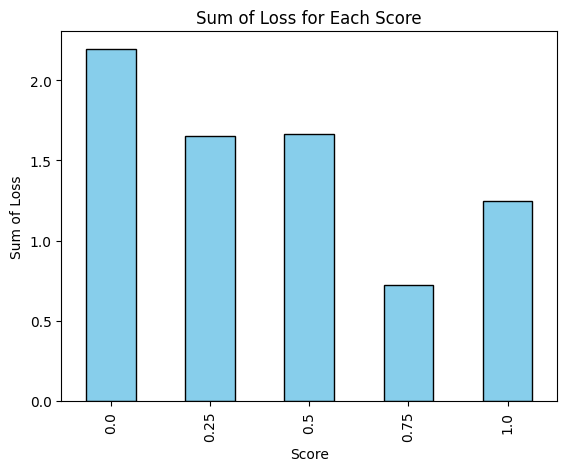

In [24]:
# loss per class
oof_df.groupby(['score'])['loss'].sum().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Sum of Loss')
plt.title('Sum of Loss for Each Score')
plt.show()

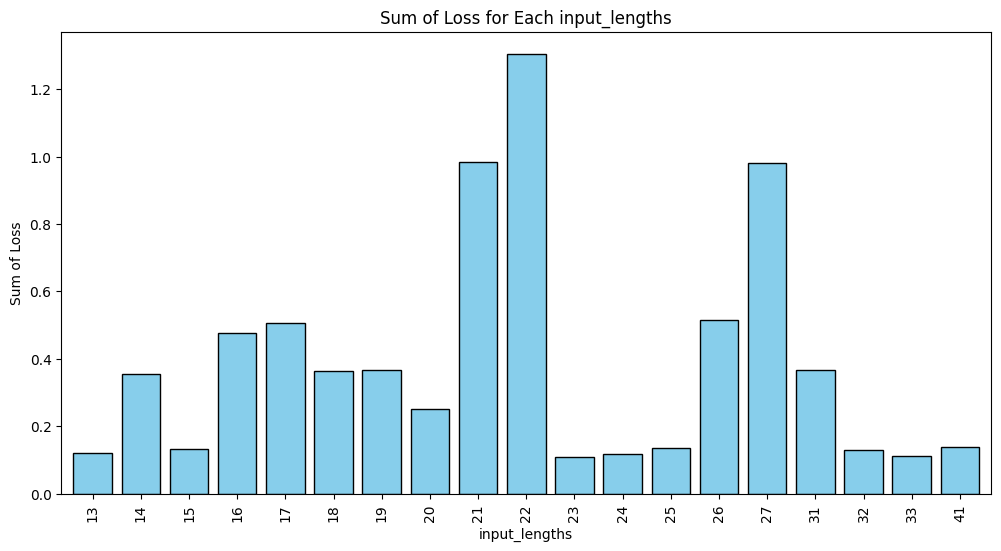

In [25]:
# relation between input lens and the loss 
# loss per input lens
plt.figure(figsize=(12, 6))
ax  = oof_df.groupby(['input_lengths'])['loss'].sum().plot(kind='bar', color='skyblue', edgecolor='black',width=0.8)
plt.xlabel('input_lengths')
plt.ylabel('Sum of Loss')
plt.title('Sum of Loss for Each input_lengths')
plt.show()

> we can go more and more to understand the errores and the ability to avoid them.

### submission

> in the comming versions we can do :  
- save best models and ensample.
- train in the all dataset.
> 

In [26]:
# use it for testing only, TODO : edit it

def tok_func(x):  return CFG.tokenizer(x["inputs"], padding=True, truncation=True) # padding true to work with the max len in the batch

test = Dataset.from_pandas(test).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [27]:
preds = model.predict(test).predictions.astype(float).flatten()

In [28]:
preds = np.clip(preds, 0, 1)

In [29]:
submission = Dataset.from_dict({
    'id': test['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1113

In [30]:
submission

Dataset({
    features: ['id', 'score'],
    num_rows: 36
})